# Reward weights analysis

The overall reward is given by
$$
R_t = R_{goal} + R_{collision} + w_1 R_{d_{goal}} + w_2 R_{speed} + w_3 R_{smooth} + w_4 R_{d_{track}}
$$
where
$$R_{dist} = \frac{d_{goal,t} - d_{goal,t-1}}{v_{max}*dt} \in [-1, 1]$$
$$R_{speed,expectile} = 1 - \frac{l_2^\tau(v_t-v_{ref}) * 2}{max(l_2^\tau(-v_{ref}), l_2^\tau(v_{max}-v_{ref}))} \in [-1, 1]$$

with expectile being defined as 
$$
l_2^\tau = \begin{cases}
    \tau x^2 & \text{if } x>0 \\
    \tau x^2 & otherwise
\end{cases}
$$

$$R_{smooth} = 1 - \frac{2}{n} \sum_i |a_{i,t}| \in [-1, 1]$$
with $a$ being the action (acceleration) at timestep $t$ and
$$R_{d_{track}} = clip(\frac{|d_{track}|}{d_{track,max}}, -1, 1)$$
where $d_{track,max}$ is a tuning parameters.

The weight vector $w = [w_1, w_2, w_3, w_4]$ sums up to 1. These weights are the main tuning parameters of the reward function. Tuning these parameters individually can be challenging even when using normalized terms. To further understand the reward function we group the terms by their purpose, i.e. if they encourage exploration (in the direction of the goal) or if they constrain the problem. 

Further we introduce a curriculum that smoothly updates a curriculum factor $k_c \in (0,1)$ as $k_{c,t+1} \leftarrow k_{c,t}^{k_d}$ where $k_d \in (0, 1)$ is an advance rate.

The reward can then be calculated as
$$
R_t = R_{goal} + (1-\alpha) \underbrace{R_{d_{goal}}}_{\text{exploration}} + k_c R_{collision} + \alpha k_c \underbrace{\left[ R_{speed} + R_{smooth} + R_{d_{track}} \right]}_{\text{constraints}}
$$

Here $\alpha$ defines the emphasis on the constraints and thus the agents behavior. The bigger $\alpha$ becomes, the harder it is to explore whereas constraints are less satisfied when $\alpha$ is low. The hypothesis is that curriculum learning enables successful learning for a higher range of $\alpha$ compared to setting $k_c=1$ from beginning on.

The questions this notebook aims to answer are:

1. What is the range of $\alpha$ that allows convergence for normal learning?
2. Can this feasible range be increased by a reward curriculum? 

# Update of k

In [3]:
import matplotlib.pyplot as plt

In [237]:
kc = 0.94
k0 = 0.001

ks = [k0]
for i in range(100):
    k = ks[-1]**kc
    ks.append(k)
ks[-1], ks[50]

(0.985905695913124, 0.7311522491848397)

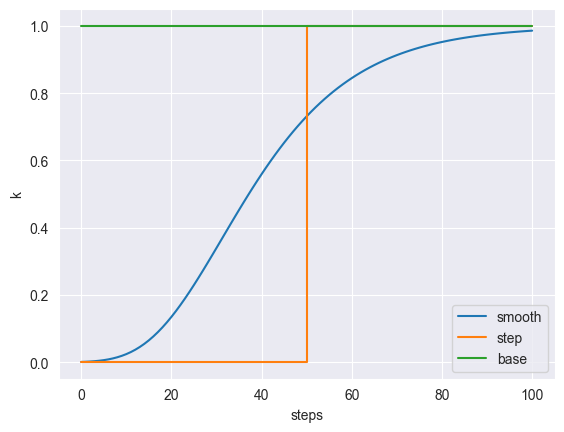

In [238]:
plt.plot(ks, label='smooth')
plt.plot([0, 50, 50.00001, 100], [0.001, 0.001, 1., 1.], label='step')
plt.plot([0, 100], [1., 1.], label='base')
plt.xlabel('steps')
plt.ylabel('k')
plt.legend()
plt.show()

# Reward curriculum to increase $\alpha$ range

In [66]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

api = wandb.Api()

def extract_data(sweep):
    data = []
    for run in sweep.runs:
        params = run.config
        metrics = run.summary
    
        reward_mode = params.get('reward_mode')
        alpha = params.get('alpha')
        map = params.get('map')
        seed = params.get('seed')
        success_rate = metrics.get('eval/episode_success')
        ep_len = metrics.get('eval/episode_length')
        ep_reward = metrics.get('eval/episode_reward')
    
        data.append({
            'reward_mode': reward_mode,
            'alpha': alpha,
            'map': map,
            'seed': seed,
            'success_rate': success_rate,
            'episode_length': ep_len,
            'episode_reward': ep_reward,
        })
    return data

In [ ]:
dynamic_sweep = api.sweep("kilian/DRL-Traj-Planner/mx52741g")
data_dynamic = extract_data(dynamic_sweep)

static_sweep = api.sweep("kilian/DRL-Traj-Planner/zee28sva")
data_static = extract_data(static_sweep)

corridor_sweep = api.sweep("kilian/DRL-Traj-Planner/if5qmjao")
data_corridor = extract_data(corridor_sweep)

In [254]:
data_curriculum_stages1 = extract_data(api.sweep("kilian/DRL-Traj-Planner/0os20a2v"))
data_curriculum_stages2 = extract_data(api.sweep("kilian/DRL-Traj-Planner/3c0gbf7o"))
data_curriculum_stages = data_curriculum_stages1 + data_curriculum_stages2

for d in data_curriculum_stages:
    d['reward_mode'] = d['reward_mode'] + "_stages"
    if d['map'] == 'generate_map_dynamic_convex_obstacle':
        data_dynamic.append(d)
    elif d['map'] == 'generate_map_static_nonconvex_obstacle':
        data_static.append(d)
    elif d['map'] == 'generate_map_corridor':
        data_corridor.append(d)
    else:
        print(f'Don\'t know how to handle {d["map"]}')

In [255]:
data_sweep_3 = extract_data(api.sweep("kilian/DRL-Traj-Planner/kj4vj5r6"))

for d in data_sweep_3:
    if d['map'] == 'generate_map_dynamic_convex_obstacle':
        data_dynamic.append(d)
    elif d['map'] == 'generate_map_static_nonconvex_obstacle':
        data_static.append(d)
    elif d['map'] == 'generate_map_corridor':
        data_corridor.append(d)
    else:
        print(f'Don\'t know how to handle {d["map"]}')

In [262]:
len(data_dynamic), len(data_static), len(data_corridor)

(99, 99, 99)

In [2]:
import numpy as np

In [19]:
def process_and_plot(data, ax, title):
    df = pd.DataFrame(data)
    df_grouped = df.groupby(['reward_mode', 'alpha']).agg({
        'success_rate': ['mean', 'std'],
        'episode_length': ['mean', 'std'],
        'episode_reward': ['mean', 'std'],
    }).reset_index()
    df_grouped.columns = ['reward_mode', 'alpha',
                          'success_rate_mean', 'success_rate_std',
                          'episode_length_mean', 'episode_length_std',
                          'episode_reward_mean', 'episode_reward_std']
    
    print(len(df_grouped))

    for mode in df_grouped['reward_mode'].unique():
        mode_data = df_grouped[df_grouped['reward_mode'] == mode]
        ax[0].plot(mode_data['alpha'], mode_data['success_rate_mean'], marker='o', label=mode)
        ax[0].fill_between(mode_data['alpha'], 
                         mode_data['success_rate_mean'] - mode_data['success_rate_std'],
                         mode_data['success_rate_mean'] + mode_data['success_rate_std'],
                         alpha=0.2)
        
        ax[1].plot(mode_data['alpha'], mode_data['episode_length_mean'], marker='o', label=mode)
        ax[1].fill_between(mode_data['alpha'], 
                         mode_data['episode_length_mean'] - mode_data['episode_length_std'],
                         mode_data['episode_length_mean'] + mode_data['episode_length_std'],
                         alpha=0.2)

        ax[2].plot(mode_data['alpha'], mode_data['episode_reward_mean'], marker='o', label=mode)
        ax[2].fill_between(mode_data['alpha'], 
                         mode_data['episode_reward_mean'] - mode_data['episode_reward_std'],
                         mode_data['episode_reward_mean'] + mode_data['episode_reward_std'],
                         alpha=0.2)

    ax[1].set_title(title+"\nEpisode Length")
    ax[0].set_title("Success")
    ax[2].set_title("Reward")
    ax[0].set_xlabel('Alpha')
    ax[0].set_ylabel('Average Success Rate')
    ax[1].set_xlabel('Alpha')
    ax[1].set_ylabel('Average Episode Length')
    ax[2].set_xlabel('Alpha')
    ax[2].set_ylabel('Average Episode Reward')
    ax[2].legend(title='Reward Mode')
    ax[0].grid(True, linestyle='--', alpha=0.7)
    ax[1].grid(True, linestyle='--', alpha=0.7)
    ax[2].grid(True, linestyle='--', alpha=0.7)
    ax[0].set_ylim([-0.2, 1.2])
    ax[1].set_ylim([80, 350])
    ax[2].set_ylim([0, 300])

33
33
33


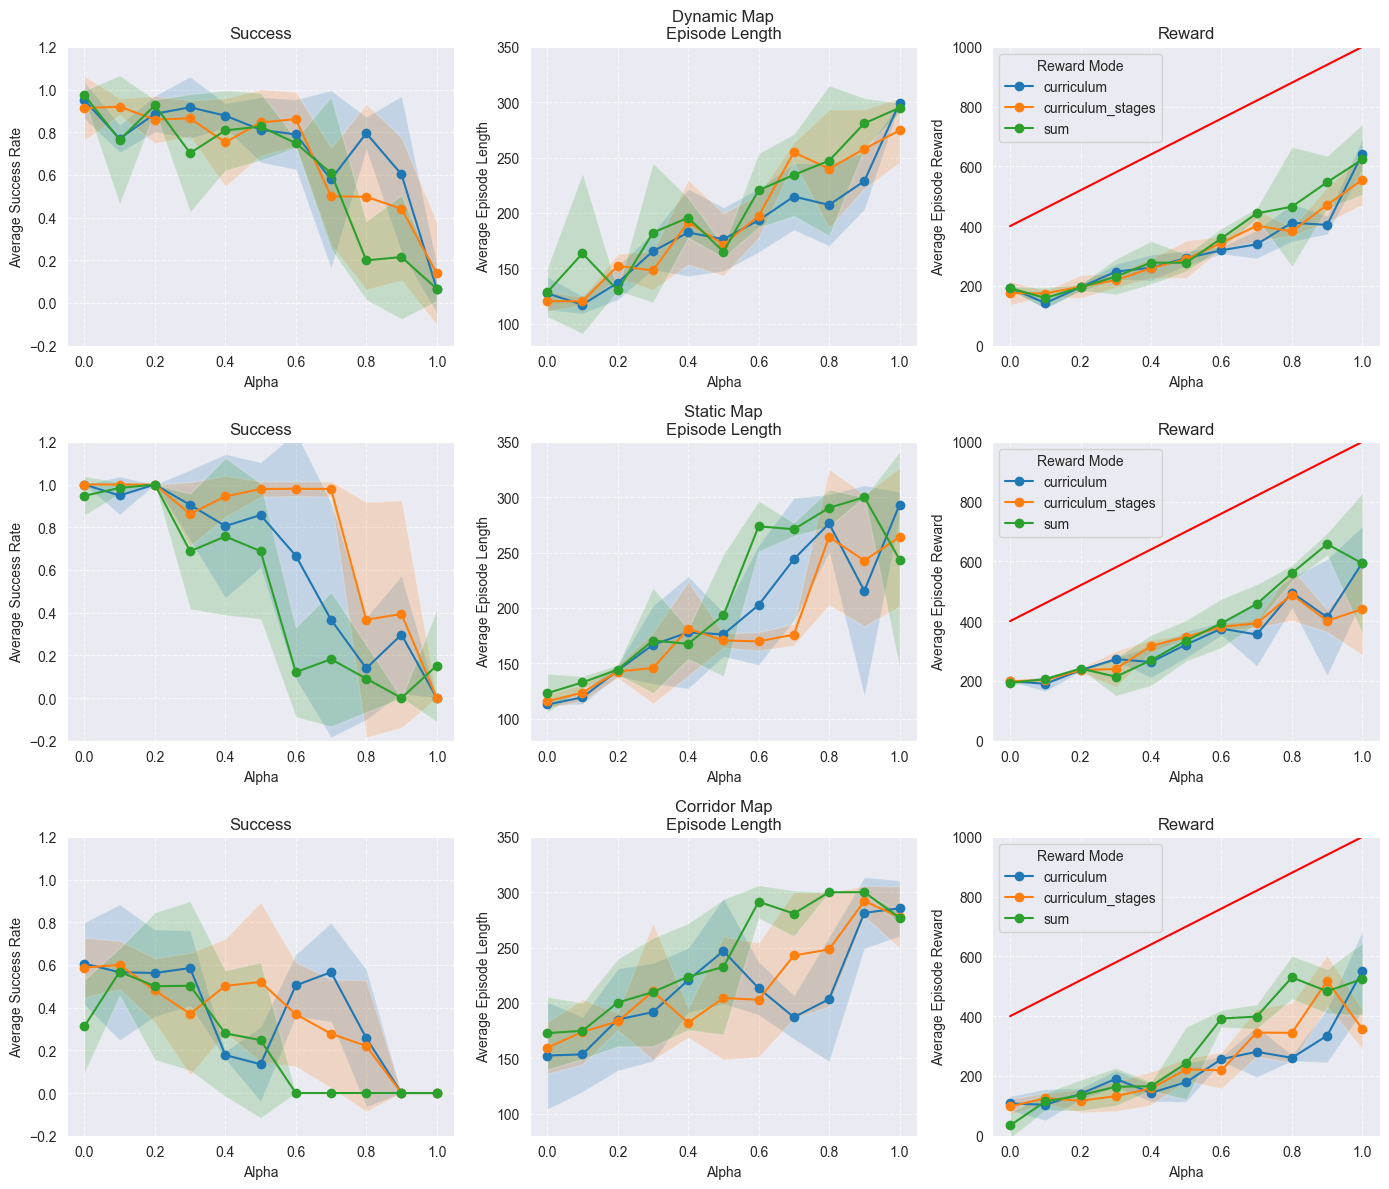

In [264]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 3, figsize=(14, 12))

process_and_plot(data_dynamic, ax1, 'Dynamic Map')
process_and_plot(data_static, ax2, 'Static Map')
process_and_plot(data_corridor, ax3, 'Corridor Map')
alpha = np.linspace(0, 1, 11)
ax1[2].plot(alpha, (1 - alpha + alpha*3)*300 + 100, color='r')
ax2[2].plot(alpha, (1 - alpha + alpha*3)*300 + 100, color='r')
ax3[2].plot(alpha, (1 - alpha + alpha*3)*300 + 100, color='r')
plt.tight_layout()
plt.show()

According to the plots a curriculum reward can enable convergence for a longer range of $\alpha$. Further, it never seems detrimental to employ curriculum learning. Note that even for $\alpha=0$, there exists a curriculum which by time increases the collision penalty. Nevertheless, it seems that the constraint terms have a higher impact of an agent's performance.

Interestingly, the episode reward and success rate do not show the same trends. A reason for this might be that the agent without curriculum learns to exploit the reward function for regions with high reward but without success whereas curriculum learning tends to prevent reward exploitation. Additionally, episodes tend to become longer with increased constraints.

Note that the exploration term has a range from $[-1, 1]$ but the constraint terms sum up to $[-3, 3]$. This explains the overall increase in episode reward when $\alpha$ increases and also why exploiting the reward function becomes an increasing problem. While this does not critically change the relation between exploration and constraint terms as it gets absorbed in $\alpha$, it can become an issue because the summed episode reward becomes much larger than the binary success reward when $\alpha$ is high.

> A policy of curriculum stages on the static non-convex map (24_08_20_12_31_09_SAC) learned not to hit obstacles, thus it also learned how to behave on the dynamic map. Nevertheless, it mostly fails when tested with a corridor scenario. 
 

What do we currently have?
- we have a way to train a model a bit more robust to reward miss-specification than without reward curriculum
- might want to fix the increased episode reward by taking mean over all constraint-rewards

What do we want to achieve?
- get a robust policy for all maps where specifying the desired behavior is easy

What is missing?
- good way to specify behavior
- training on all maps


Options
- find unified way for a reward-environment curriculum
- move towards MORL to specify behavior online

# Experiments v2
- Divide constraints by 3 and rerun experiments
- Test kl regularization between curriculum step-phases

In [67]:
api = wandb.Api()

In [68]:
data_curriculum_exp2 = extract_data(api.sweep("kilian/DRL-Traj-Planner/v96w8oow"))

In [80]:
# Initialize a set to keep track of unique (reward_mode, seed) combinations
def get_unique_dicts(list_of_dicts):
    seen = set()
    filtered_list = []
    for d in list_of_dicts:
        unique_key = (d['reward_mode'], d['seed'], d['alpha'])
        
        if unique_key not in seen:
            seen.add(unique_key)
            filtered_list.append(d)
    return filtered_list

In [86]:
data_dynamic = [d for d in data_curriculum_exp2 if d['map'] == 'generate_map_dynamic_convex_obstacle']
data_static = [d for d in data_curriculum_exp2 if d['map'] == 'generate_map_static_nonconvex_obstacle']
data_corridor = [d for d in data_curriculum_exp2 if d['map'] == 'generate_map_corridor']

data_static = get_unique_dicts(data_static)
data_corridor = get_unique_dicts(data_corridor)

len(data_dynamic), len(data_static), len(data_corridor)

(99, 98, 99)

33
33
33


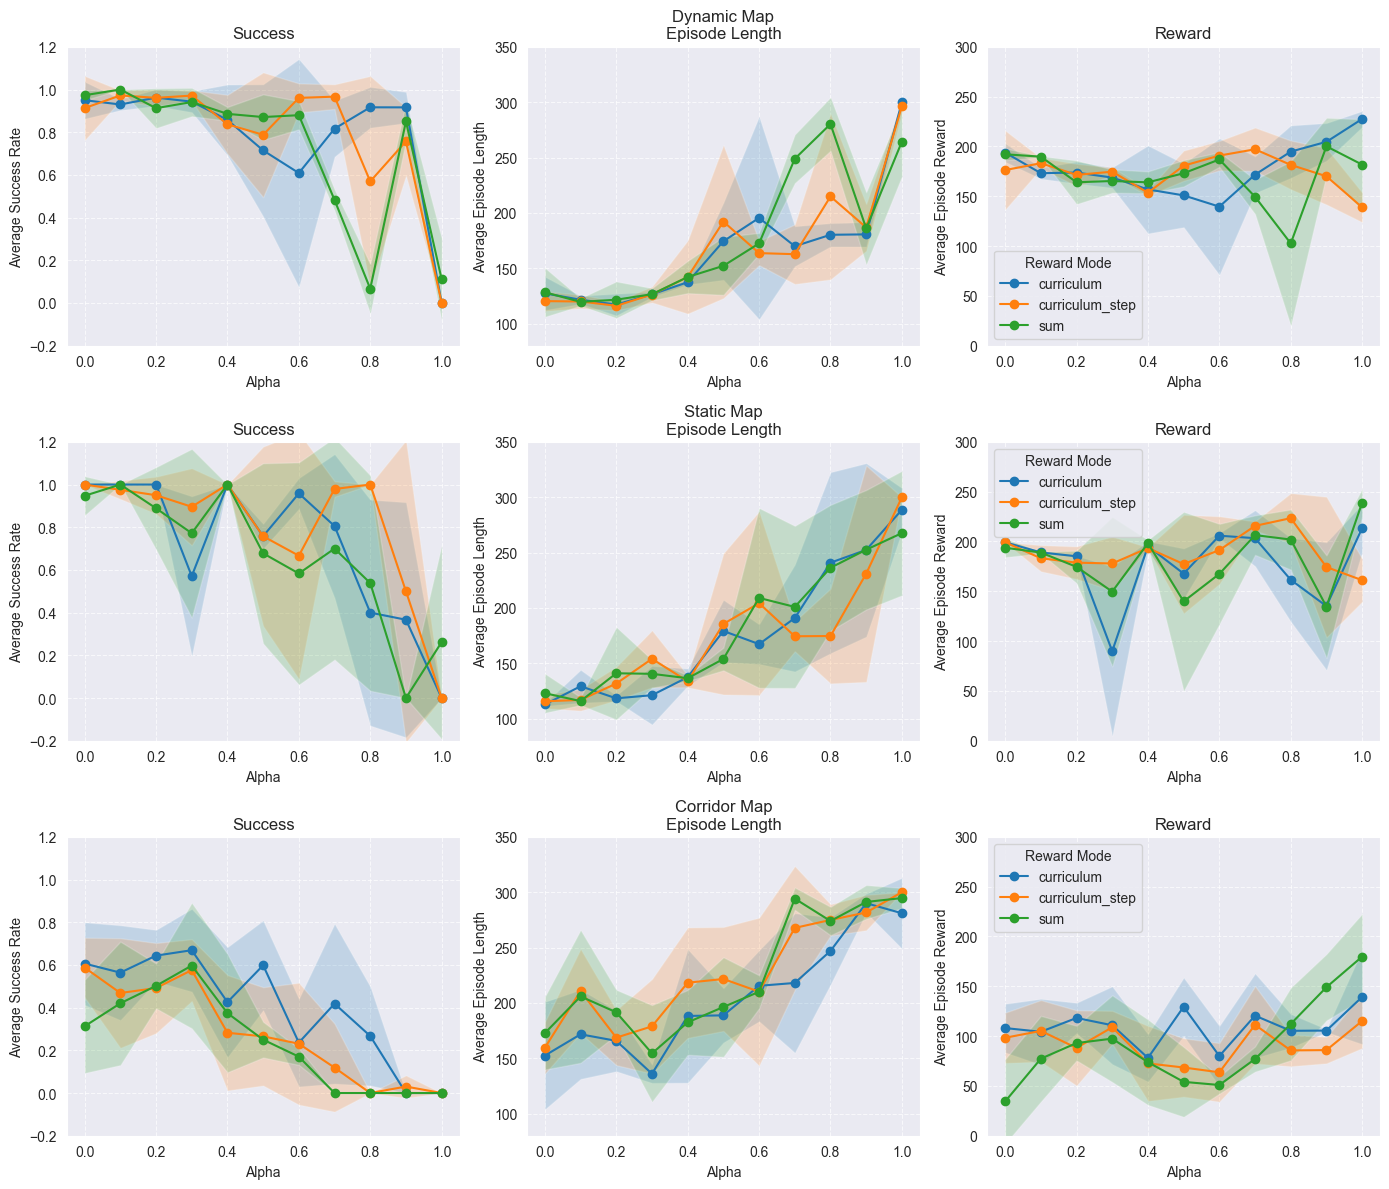

In [87]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 3, figsize=(14, 12))

process_and_plot(data_dynamic, ax1, 'Dynamic Map')
process_and_plot(data_static, ax2, 'Static Map')
process_and_plot(data_corridor, ax3, 'Corridor Map')
plt.tight_layout()
plt.show()

When rewards are balanced the differences are not as distinct anymore. While the curriculum approaches are slightly better they do not yield a substantially improved training. An overall pattern is that the episode length increases with constraints. A reason for the failure of all approaches in later stages could be the difficulty of finding the goal at all, as the goal distance term becomes very small.

> TODO look into the success rate @50k of curriculum step. If it is much higher than the final one, then we might want to use a KL-regularized curriculum.

A study that could give more insights might be to keep the exploration terms fixed and only vary constraints. Then, we would expect that curriculum approaches clearly outperform summing rewards with high constraints. Nonetheless, we would encounter the same problem as above where the cumulative reward would increase constantly. It is not clear for now how to avoid that problem.

- Design experiment with constant explorations where more and more emphasis is put on the constraints
- Here, KL-regularized curriculum should work well

## Preliminary study
1. Find setting with high constraints where summed learning fails.
2. Test KL-regularized curriculum. How do we tune KL weight here?

Here the exploration terms have weight 1 and the constraints weight 2

In [2]:
import wandb

In [30]:
def extract_data(run_ids):
    data = []
    episode_lengths = []
    episode_rewards = []

    for run_id in run_ids:
        run = api.run(f'{project}/{run_id}')
        summary = run.summary
        success_rate = summary.get('eval/episode_success')
        episode_length = summary.get('eval/episode_length')
        episode_reward = summary.get('eval/episode_reward')
        data.append(success_rate)
        episode_lengths.append(episode_length)
        episode_rewards.append(episode_reward)

    return data, episode_lengths, episode_rewards

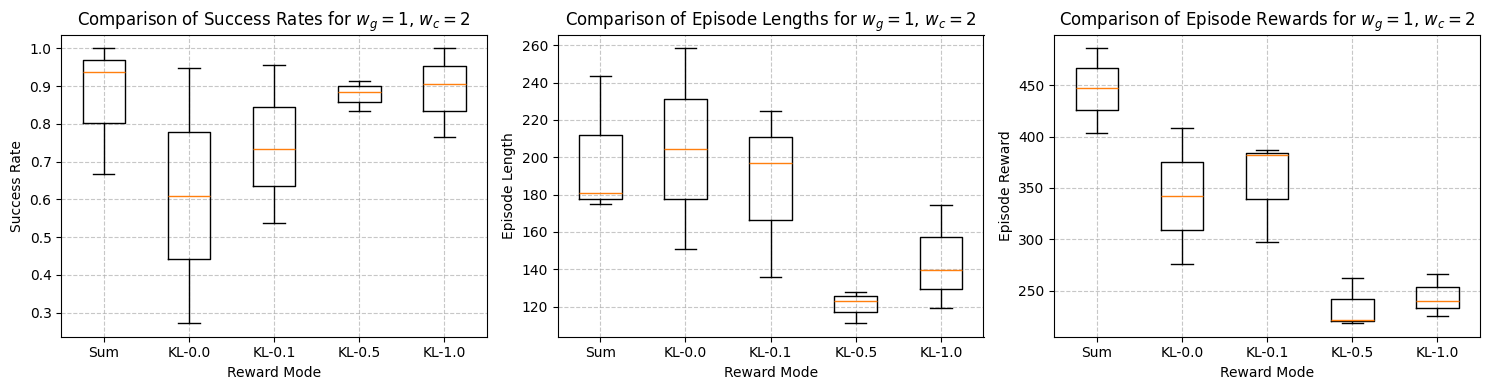

In [38]:
import matplotlib.pyplot as plt

sum_ids = ['bs38pys6', '63qwun1p', '4nylvsam']
kl_00_ids = ['1hultvx0', 'esxrmrck'] # FIXME remove duplicate '7y7w5cev'
kl_01_ids = ['d39aj49v', 'xdqbf6es', 'i1uu0ts0']
kl_05_ids = ['11rvzee4', 'jvwb53xd', 'zdrjof6v']
kl_10_ids = ['dntv7jbd', 'u48eeap1', 'hhv9y9io']

sum_data, sum_episode_lengths, sum_episode_rewards = extract_data(sum_ids)
kl_00_data, kl_00_episode_lengths, kl_00_episode_rewards = extract_data(kl_00_ids)
kl_01_data, kl_01_episode_lengths, kl_01_episode_rewards = extract_data(kl_01_ids)
kl_05_data, kl_05_episode_lengths, kl_05_episode_rewards = extract_data(kl_05_ids)
kl_10_data, kl_10_episode_lengths, kl_10_episode_rewards = extract_data(kl_10_ids)

labels = ['Sum', 'KL-0.0', 'KL-0.1', 'KL-0.5', 'KL-1.0']
data = [sum_data, kl_00_data, kl_01_data, kl_05_data, kl_10_data]
episode_lengths = [sum_episode_lengths, kl_00_episode_lengths, kl_01_episode_lengths, kl_05_episode_lengths, kl_10_episode_lengths]
episode_rewards = [sum_episode_rewards, kl_00_episode_rewards, kl_01_episode_rewards, kl_05_episode_rewards, kl_10_episode_rewards]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.boxplot(data, tick_labels=labels)
ax1.set_xlabel('Reward Mode')
ax1.set_ylabel('Success Rate')
ax1.set_title('Comparison of Success Rates for $w_g = 1$, $w_c = 2$')
ax1.grid(True, linestyle='--', alpha=0.7)

ax2.boxplot(episode_lengths, tick_labels=labels)
ax2.set_xlabel('Reward Mode')
ax2.set_ylabel('Episode Length')
ax2.set_title('Comparison of Episode Lengths for $w_g = 1$, $w_c = 2$')
ax2.grid(True, linestyle='--', alpha=0.7)

ax3.boxplot(episode_rewards, tick_labels=labels)
ax3.set_xlabel('Reward Mode')
ax3.set_ylabel('Episode Reward')
ax3.set_title('Comparison of Episode Rewards for $w_g = 1$, $w_c = 2$')
ax3.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

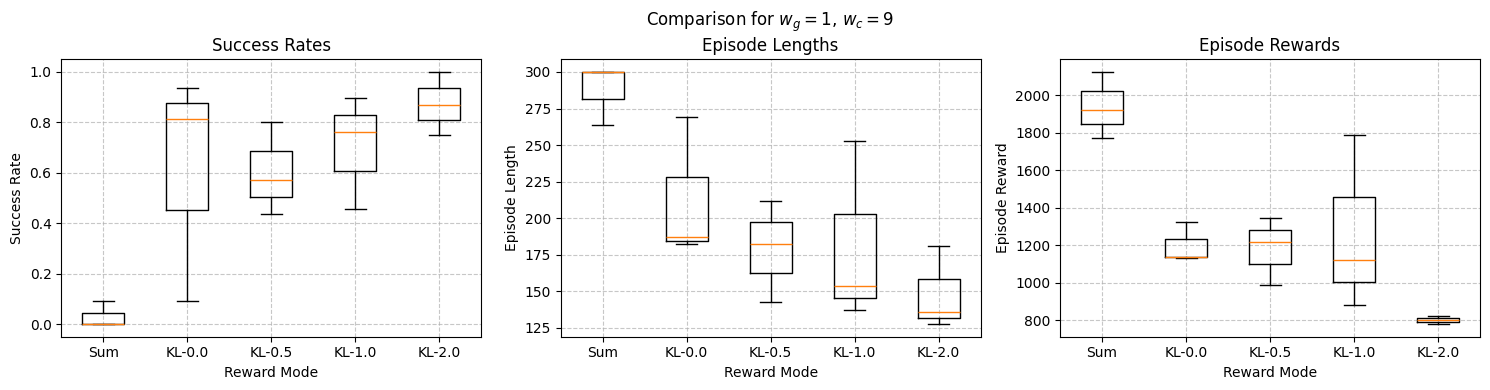

In [55]:
import matplotlib.pyplot as plt

api = wandb.Api()
sum_ids = ['5i3xjwp0', 'chd7bntp', 'un0f3bip']
kl_00_ids = ['huf1z752', 'h8oq7hh5', '3ro7hzko'] 
kl_05_ids = ['ggimew29', '9khxhe5d', 'v6rs6y0z']
kl_10_ids = ['xjftmgub', 'odupfuz9', '3p3psobl']
kl_20_ids = ['74zupxof', 'f7778eu8', '34xy2ykn']

sum_data, sum_episode_lengths, sum_episode_rewards = extract_data(sum_ids)
kl_00_data, kl_00_episode_lengths, kl_00_episode_rewards = extract_data(kl_00_ids)
kl_05_data, kl_05_episode_lengths, kl_05_episode_rewards = extract_data(kl_05_ids)
kl_10_data, kl_10_episode_lengths, kl_10_episode_rewards = extract_data(kl_10_ids)
kl_20_data, kl_20_episode_lengths, kl_20_episode_rewards = extract_data(kl_20_ids)

labels = ['Sum', 'KL-0.0', 'KL-0.5', 'KL-1.0', 'KL-2.0']
data = [sum_data, kl_00_data, kl_05_data, kl_10_data, kl_20_data]
episode_lengths = [sum_episode_lengths, kl_00_episode_lengths, kl_05_episode_lengths, kl_10_episode_lengths, kl_20_episode_lengths]
episode_rewards = [sum_episode_rewards, kl_00_episode_rewards, kl_05_episode_rewards, kl_10_episode_rewards, kl_20_episode_rewards]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.boxplot(data, tick_labels=labels)
ax1.set_xlabel('Reward Mode')
ax1.set_ylabel('Success Rate')
ax1.set_title('Success Rates')
ax1.grid(True, linestyle='--', alpha=0.7)

ax2.boxplot(episode_lengths, tick_labels=labels)
ax2.set_xlabel('Reward Mode')
ax2.set_ylabel('Episode Length')
ax2.set_title('Comparison for $w_g = 1$, $w_c = 9$\nEpisode Lengths')
ax2.grid(True, linestyle='--', alpha=0.7)

ax3.boxplot(episode_rewards, tick_labels=labels)
ax3.set_xlabel('Reward Mode')
ax3.set_ylabel('Episode Reward')
ax3.set_title('Episode Rewards')
ax3.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()